# ASL Alphabet CNN

In [1]:
!pip install split-folders

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import splitfolders
splitfolders.ratio("/home/rkuo/Datasets/ASL_alphabet/train", output="datasets/ASL_alphabet",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 87000 files [00:02, 32855.59 files/s]


In [3]:
train_dir = 'datasets/ASL_alphabet/train'
val_dir = 'datasets/ASL_alphabet/val'
test_dir  = 'datasets/ASL_alphabet/test'

## Prepare Dataset

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

batch_size = 16
target_size = (32,32) # dataset pic = 200x200

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

2024-04-17 23:39:13.106411: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 23:39:13.126992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 23:39:13.435115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 69600 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [5]:
labels = list(train_generator.class_indices.keys())
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


## Show Dataset

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
TRAIN_PATH = train_dir
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

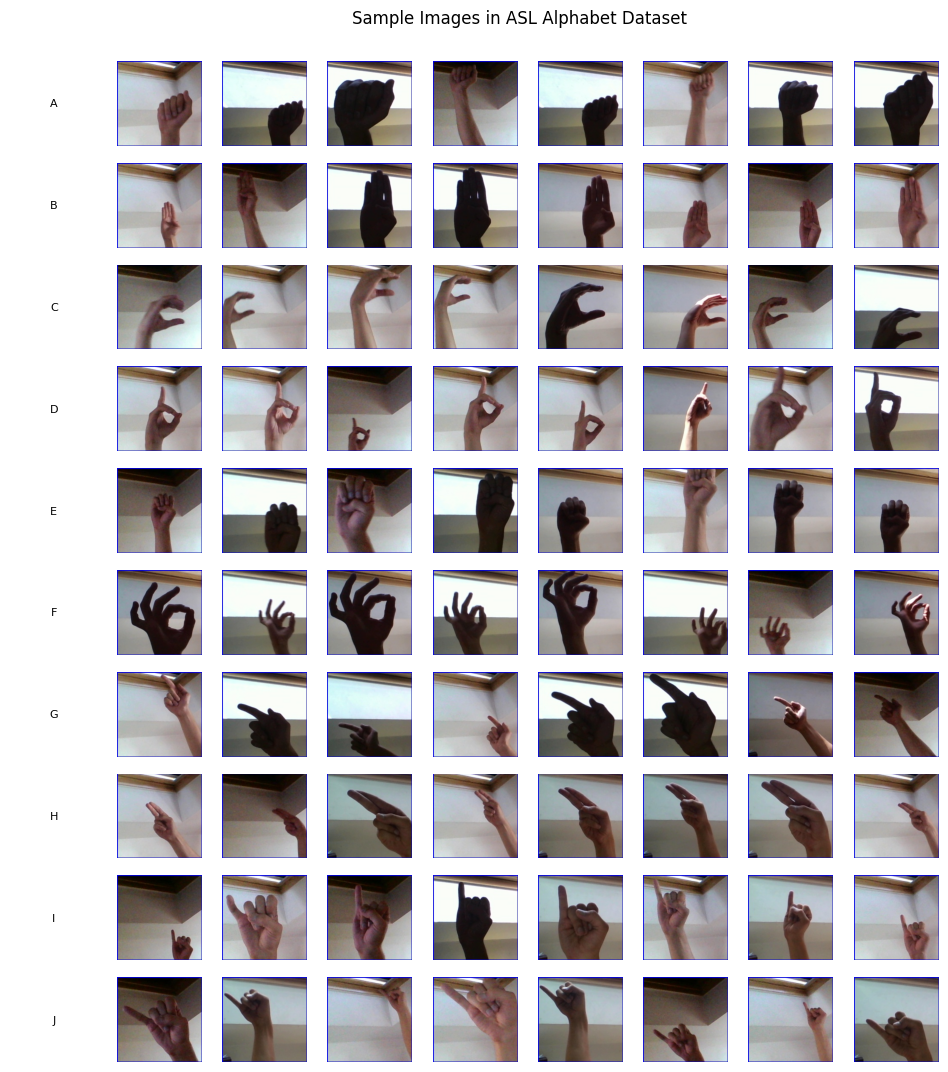

In [7]:
sample_images(labels[:10])

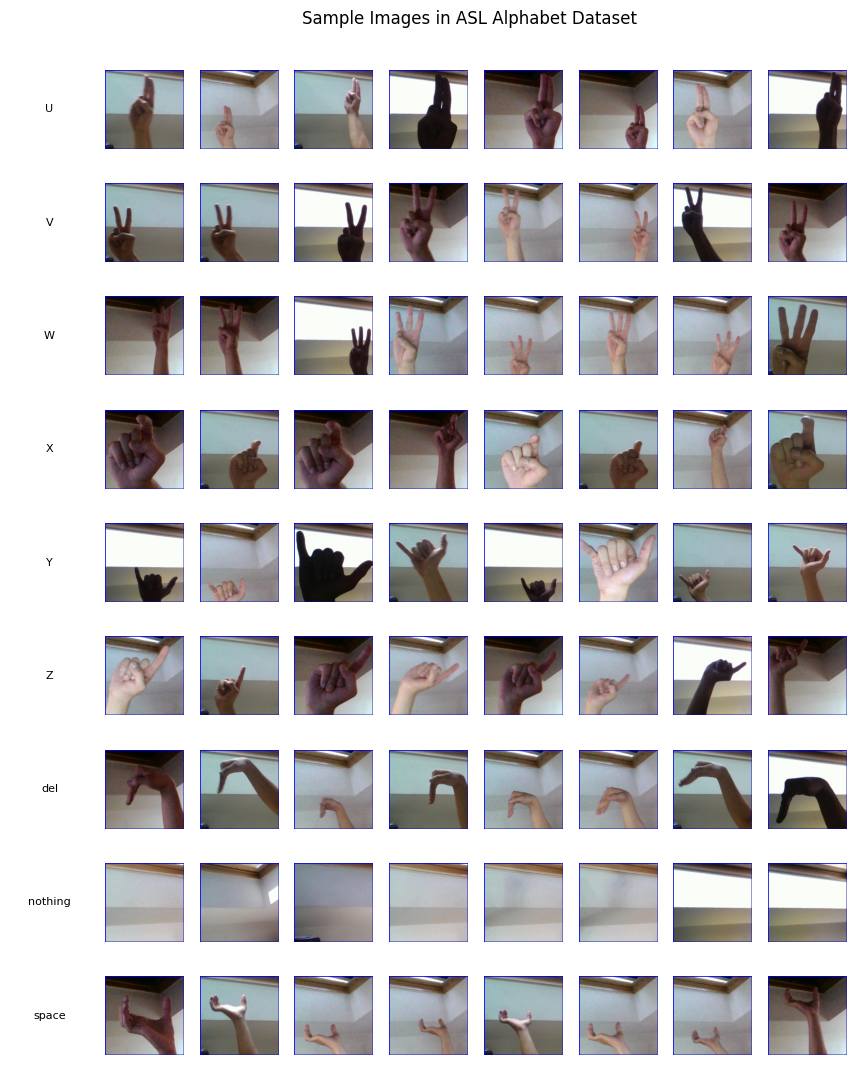

In [8]:
sample_images(labels[20:])

## Build Model

In [9]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense

In [10]:
num_classes = len(labels)
input_shape = (32,32,1)

In [11]:
# Build Model
model = models.Sequential()
# 1st convolution layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# 2nd convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# 3rd convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# fully-connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

/home/rkuo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-17 23:39:17.011601: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 23:39:17.028163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 23:39:17.028259: I e

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,685 (619.86 KB)

 Trainable params: 158,461 (618.99 KB)

 Non-trainable params: 224 (896.00 B)

In [12]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

## Train Model

In [13]:
history = model.fit(train_generator, validation_data=val_generator, epochs=30)

Epoch 1/30


/home/rkuo/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713368357.913389   69307 service.cc:145] XLA service 0x5f7290f0b140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713368357.913403   69307 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-04-17 23:39:17.935454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-17 23:39:18.031477: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  43/4350 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0730 - loss: 3.6208 

I0000 00:00:1713368359.413716   69307 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6625 - loss: 1.1239 - val_accuracy: 0.8957 - val_loss: 0.3134
Epoch 2/30
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9555 - loss: 0.1284 - val_accuracy: 0.9571 - val_loss: 0.1288
Epoch 3/30
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9762 - loss: 0.0734 - val_accuracy: 0.9662 - val_loss: 0.0988
Epoch 4/30
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9820 - loss: 0.0557 - val_accuracy: 0.9806 - val_loss: 0.0555
Epoch 5/30
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9850 - loss: 0.0471 - val_accuracy: 0.9722 - val_loss: 0.0796
Epoch 6/30
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9877 - loss: 0.0395 - val_accuracy: 0.8364 - val_loss: 0.8231
Epoch 7/30
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9885 - loss: 0.0370 - val_accuracy: 0.9715 - val_loss: 0.1084
Epoch 8/30
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9905 - loss: 0.0299 - val

## Evaluate Model

In [14]:
scores = model.evaluate(test_generator) 
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9982 - loss: 0.0062
Test loss:  0.007393097039312124
Test accuracy:  0.9979310631752014


## Save Model

In [15]:
model.save("asl_alphabet_cnn.h5")